In [5]:
%matplotlib inline
from fig_config import *
from mxnet import gluon, image
from mxnet.gluon import utils as gutils
import os

def _download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    
    for k, v in dataset.items():
        gutils.download(root_url + k, os.path.join(data_dir, k), sha1_hash=v)


((32, 3, 256, 256), (32, 1, 5))

In [ ]:
##读取数据集
def load_data_pikachu(batch_size, edge_size=256):  # edge_size：输出图像的宽和高
    data_dir = '../data/pikachu'
    _download_pikachu(data_dir)
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),##提供图像索引文件，以随机读取小批量
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),
        shuffle=True,##以随机顺序读取训练数据集
        rand_crop=1,##进行随机裁剪
        min_object_covered=0.95,##裁剪出的图像至少覆盖每个目标95%的区域
        max_attempts=200)##最多尝试200次随机裁剪
    val_iter = image.ImageDetIter(#不随机裁剪测试数据集中的图像
        path_imgrec=os.path.join(data_dir, 'val.rec'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),
        shuffle=False)##无须按随机顺序读取测试数据集
    return train_iter, val_iter
    

In [23]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
## 图像的形状：(批量大小, 通道数, 高, 宽)
## 标签的形状则是(批量大小,  m , 5)
## m等于数据集中单个图像最多含有的边界框个数, 
## 每个边界框的标签由长度为5的数组表示: 这里的标签也就是皮卡丘的标签，位置等信息
## 数组中第一个元素是边界框所含目标的类别
## 数组的剩余4个元素分别表示边界框左上角的 x 和 y 轴坐标以及右下角的 x 和 y 轴坐标
batch.data[0].shape, batch.label[0].shape


((32, 3, 256, 256), (32, 1, 5))

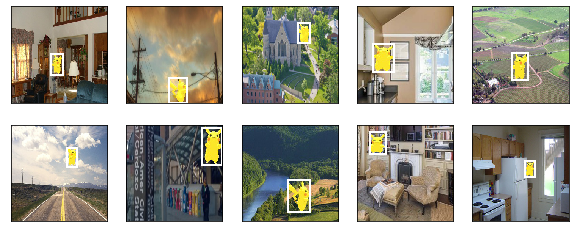

In [17]:
def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh包中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):##使obj为list或者tuple类型
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.asnumpy(), color)##为什么要变换成numpy类型？？
        axes.add_patch(rect)
        if labels and len(labels) > i:##输出方框的标签
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                     va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))


In [ ]:
def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes


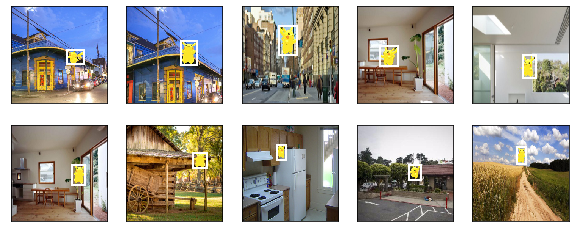

In [24]:
imgs = (batch.data[0][0:10].transpose((0, 2, 3, 1))) / 255##transpose((0, 2, 3, 1))什么意思
axes = show_images(imgs, 2, 5).flatten()
for axe, label in zip(axes, batch.label[0][0:10]):
    show_bboxes(axe, [label[0][1:5] * edge_size], colors=['w'])
